In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

In [151]:
plt.style.use("ggplot")

### 1. Data understanding and cleaning

In [152]:
data = pd.read_csv("train (1).csv")

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [154]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


#### Checking for null values

In [155]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
                              ...    
last_day_rch_amt_8           0.000000
vol_2g_mb_6                  0.000000
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
churn_probability            0.000000
Length: 172, dtype: float64

Let's drop all the features having more than 70% of null values

In [156]:
data.dropna(thresh=len(data.index) * 0.7, axis=1, inplace=True)

In [157]:
data.shape

(69999, 142)

#### Dropping redundant feature

##### Low variance feature

In [158]:
redundant_cols = []
for col in data.columns:
    counts = data[col].value_counts()
    count_max = counts.iloc[0]
    if count_max / len(data) * 100 > 95:
        redundant_cols.append(col)
redundant_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'og_others_7',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [159]:
data.loc_og_t2o_mou.value_counts()

0.0    69297
Name: loc_og_t2o_mou, dtype: int64

In [160]:
data.circle_id.value_counts()

109    69999
Name: circle_id, dtype: int64

These values have very low variance and it does not contain any information, so lets drop these features

In [161]:
data.drop(redundant_cols, axis=1, inplace=True)

##### Dropping id

In [162]:
data.drop("id", axis=1, inplace=True)

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(100), int64(23), object(3)
memory usage: 67.3+ MB


#### Data transformation

##### Lets have a look at the object types

In [164]:
data.select_dtypes('object').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These are all datetime fields.

In [165]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.year.value_counts()

2014.0    68898
Name: date_of_last_rech_6, dtype: int64

In [166]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.month.value_counts()

6.0    68898
Name: date_of_last_rech_6, dtype: int64

For each of these fields month and year are the same, so we can remove them and just keep the day

In [167]:
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [168]:
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [169]:
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(103), int64(23)
memory usage: 67.3 MB


##### Lets no replace all null values with median

In [171]:
data.fillna(data.median(), inplace=True)

In [172]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_6               0.0
total_ic_mou_6       0.0
total_rech_num_7     0.0
total_rech_num_6     0.0
ic_others_8          0.0
                    ... 
std_og_t2f_mou_7     0.0
std_og_t2f_mou_6     0.0
std_og_t2m_mou_8     0.0
std_og_t2m_mou_7     0.0
churn_probability    0.0
Length: 126, dtype: float64

#### Feature engineering

##### Adding column of average revenue per user for all three months

In [173]:
data["arpu"] = (data["arpu_6"] + data["arpu_7"] + data["arpu_8"] ) / 3

In [174]:
data["arpu"].describe([0.9, 0.95, 0.97, 0.98])

count    69999.000000
mean       280.059701
std        310.243414
min         13.426667
50%        199.662667
90%        584.719133
95%        773.942000
97%        920.071487
98%       1050.861547
max      32140.182000
Name: arpu, dtype: float64

We can see that there are some really high value customers

##### Adding column of total recharge done by customer for all three months

In [175]:
data["total_rech_amt"] = data["total_rech_amt_6"] + data["total_rech_amt_7"] + data["total_rech_amt_8"]

In [176]:
data["total_rech_amt"].describe([0.9, 0.95, 0.97, 0.98])

count     69999.000000
mean        974.362505
std        1106.099526
min           0.000000
50%         692.000000
90%        2052.000000
95%        2724.100000
97%        3238.000000
98%        3708.040000
max      120845.000000
Name: total_rech_amt, dtype: float64

##### Adding total data usags

In [177]:
data["total_vol_2g_3g"] = data["vol_2g_mb_6"] + data["vol_2g_mb_7"] + data["vol_2g_mb_8"] + data["vol_3g_mb_6"] + data["vol_3g_mb_7"] + data["vol_3g_mb_8"]

##### Adding total min of usage

In [178]:
data["total_mou"] = data["onnet_mou_6"] + data["onnet_mou_7"] + data["onnet_mou_8"] + data["offnet_mou_6"] + data["offnet_mou_7"] + data["offnet_mou_8"]

##### Create High Value Customer data frame based on above two columns

In [179]:
# data_hvc = data[ 
#     ( ( data["arpu"] >= data["arpu"].quantile(0.70) ) & ( data["arpu"] < data["arpu"].quantile(0.999) )) | 
#     ( ( data["total_rech_amt"] >= data["total_rech_amt"].quantile(0.70) ) & 
#      ( data["total_rech_amt"] < data["total_rech_amt"].quantile(0.999) ) ) ]

data = data[ 
    (  data["arpu"] < data["arpu"].quantile(0.99) ) | 
    ( data["total_rech_amt"] < data["total_rech_amt"].quantile(0.99) ) ]

In [180]:
data.shape

(69363, 130)

### 2. EDA

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69363 entries, 0 to 69998
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 69.3 MB


##### Target variable distribution

In [182]:
data.churn_probability.value_counts()

0    62271
1     7092
Name: churn_probability, dtype: int64

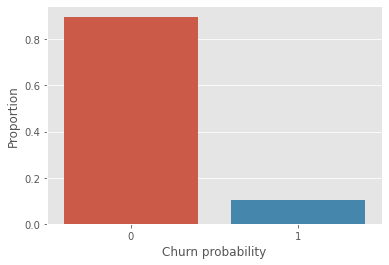

In [183]:
sns.barplot(data=data["churn_probability"].value_counts(normalize=True).reset_index(),
            x="index", y="churn_probability")
plt.xlabel("Churn probability")
plt.ylabel("Proportion")
plt.show()

The distribution of churn and not churn is clearly not equally distributed

##### Relationship of target variable and total_rech_amt

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt'>

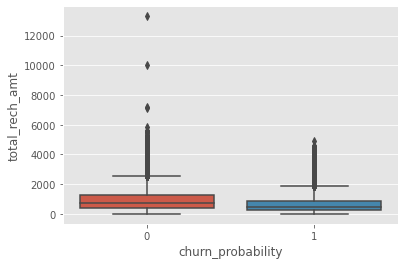

In [184]:
sns.boxplot(data=data, x="churn_probability", y="total_rech_amt")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_8'>

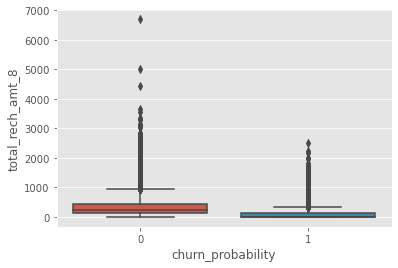

In [185]:
sns.boxplot(data=data, x="churn_probability", y="total_rech_amt_8")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_7'>

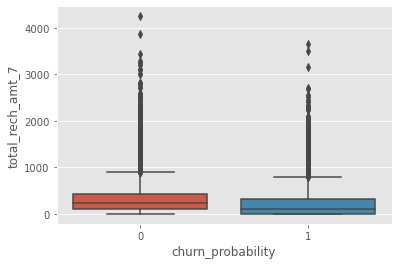

In [186]:
sns.boxplot(data=data, x="churn_probability", y="total_rech_amt_7")

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt_6'>

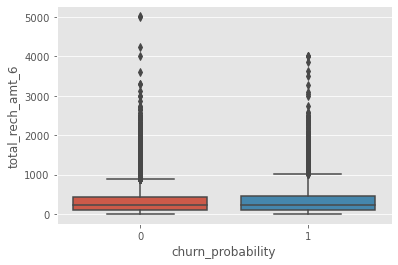

In [187]:
sns.boxplot(data=data, x="churn_probability", y="total_rech_amt_6")

We can see from here that if customer is recharging less consecutively from june to july to august he/she is more likely to churn

##### Relationship of target variable and arpu

<AxesSubplot:xlabel='churn_probability', ylabel='arpu'>

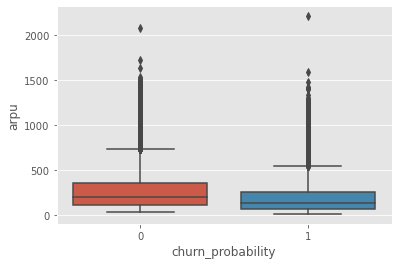

In [188]:
sns.boxplot(data=data, x="churn_probability", y="arpu")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_8'>

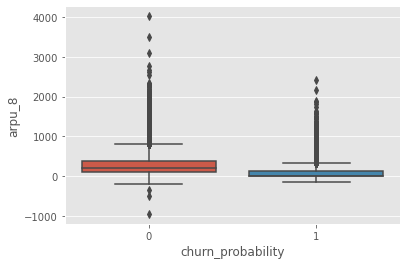

In [189]:
sns.boxplot(data=data, x="churn_probability", y="arpu_8")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_7'>

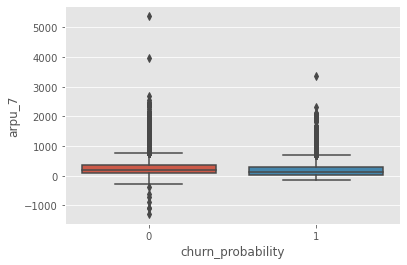

In [190]:
sns.boxplot(data=data, x="churn_probability", y="arpu_7")

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_6'>

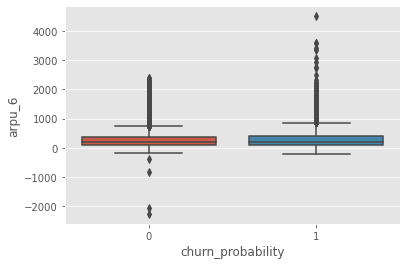

In [191]:
sns.boxplot(data=data, x="churn_probability", y="arpu_6")

Similarly if the revenue of the customer is descreasing month over month, she/he is likely to churn

##### Target variable with data volume consumed

<AxesSubplot:xlabel='churn_probability', ylabel='total_vol_2g_3g'>

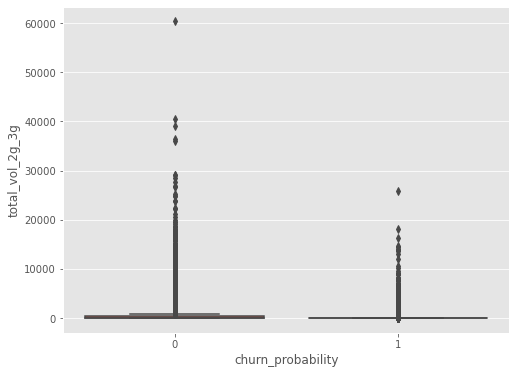

In [192]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x="churn_probability", y="total_vol_2g_3g")

Trend is low data consumption customers are likely to churn

##### Churn vs last recharge

<AxesSubplot:xlabel='churn_probability', ylabel='date_of_last_rech_8'>

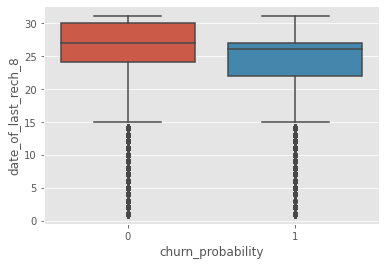

In [193]:
sns.boxplot(data=data, x="churn_probability", y="date_of_last_rech_8")

Not a significance difference, but if a customer has not recharged lately, then she/he is likely to churn

##### Target and age on network

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

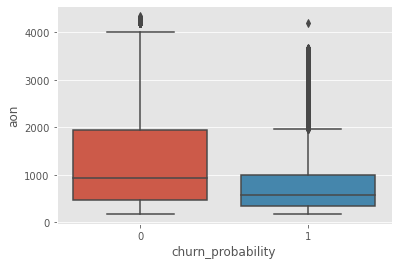

In [194]:
sns.boxplot(data=data, x="churn_probability", y="aon")

Here we can see if user age on the network is more, he/she is less likely to churn

##### Churn vs min usages

<AxesSubplot:xlabel='churn_probability', ylabel='total_mou'>

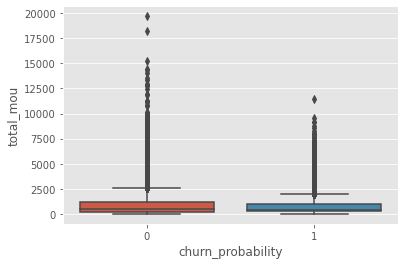

In [195]:
sns.boxplot(data=data, x="churn_probability", y="total_mou")

We can see much difference, let see in details month wise

<AxesSubplot:xlabel='churn_probability'>

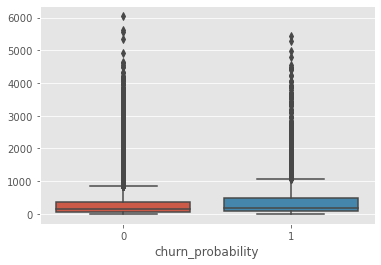

In [196]:
sns.boxplot(data=data, x="churn_probability", y=data["onnet_mou_6"] + data["offnet_mou_6"])

<AxesSubplot:xlabel='churn_probability'>

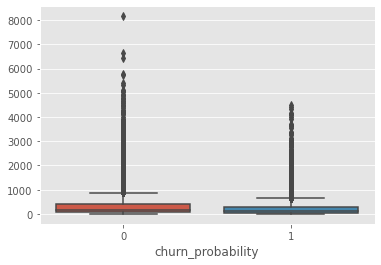

In [197]:
sns.boxplot(data=data, x="churn_probability", y=data["onnet_mou_7"] + data["offnet_mou_7"])

<AxesSubplot:xlabel='churn_probability'>

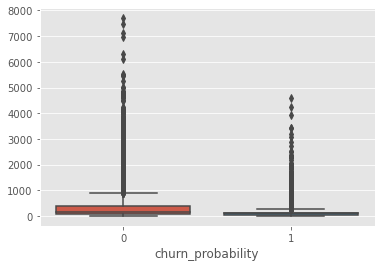

In [198]:
sns.boxplot(data=data, x="churn_probability", y=data["onnet_mou_8"] + data["offnet_mou_8"])

Here we can see that if usage is declining the customer is likely to churn

**Performing EDA gave us following insights**
- If customer is recharging less month on month he/she is likely to churn
- If customer's revenue is decreasing month on month he/she is likely to churn
- Customer consuming less internet data is likely to churn
- If is a customer has not done recharge lately, he/she might end up churning
- Customer who is using the network for long enough is not likely to churn
- If total voice call usage is declining month over month customer will likely churn

## 3. Data preparation

##### Checking for correlation

In [199]:
cor = data.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

total_ic_mou_8    loc_ic_t2m_mou_7    0.602712
std_og_t2m_mou_8  offnet_mou_7        0.605349
total_vol_2g_3g   jul_vbc_3g          0.605787
std_ic_mou_6      std_ic_t2m_mou_7    0.606345
monthly_3g_8      vol_3g_mb_8         0.607377
                                        ...   
total_mou         total_og_mou_7      0.920315
total_rech_amt_6  arpu_6              0.927123
total_rech_amt_7  arpu_7              0.928217
total_rech_amt_8  arpu_8              0.932994
total_rech_amt    arpu                0.979842
Length: 229, dtype: float64

There are quiet a few number of correlated features but we'll not remove those, as we'll go ahead and do PCA

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69363 entries, 0 to 69998
Columns: 130 entries, arpu_6 to total_mou
dtypes: float64(106), int64(24)
memory usage: 71.3 MB


#### Splitting the data

In [201]:
y = data.pop("churn_probability")
X = data

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, 
                                                    random_state=1)

In [203]:
scaler = StandardScaler()

In [204]:
X_train = scaler.fit_transform(X_train)

In [205]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-0.609186,-0.362384,-0.712811,-0.446780,-0.402040,-0.389994,-0.506614,-0.387986,-0.555831,-0.167675,...,-0.208292,-0.219783,0.266391,-0.262807,-0.251644,-0.237225,-0.653306,-0.650741,0.016442,-0.661897
1,2.540099,1.324322,-1.016001,0.097347,-0.201865,-0.445115,5.351857,2.629311,-0.650444,-0.167675,...,-0.208292,-0.219783,-0.637367,-0.262807,-0.251644,-0.237225,1.097822,1.061505,-0.369202,1.681367
2,-0.465146,-0.627772,-0.713138,-0.430023,-0.420893,-0.444454,-0.508305,-0.618367,-0.390678,-0.167675,...,-0.208292,-0.219783,-0.305674,-0.262807,-0.251644,-0.237225,-0.699838,-0.709084,-0.056325,-0.692579
3,-0.281760,-0.035883,-0.303731,-0.418607,-0.410750,-0.384743,-0.144031,0.029265,-0.162652,-0.167675,...,-0.208292,-0.219783,-0.195460,-0.262807,-0.251644,-0.237225,-0.241326,-0.271510,-0.369202,-0.364378
4,-0.719345,-0.650584,-0.516875,-0.452672,-0.437272,-0.424036,-0.494810,-0.380527,-0.264183,-0.167675,...,-0.208292,-0.219783,2.177824,-0.262807,-0.251644,-0.237225,-0.730587,-0.627911,-0.369202,-0.602894


In [206]:
X_test = scaler.transform(X_test)

In [207]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,2.335897,2.421067,2.001530,0.912451,0.811878,0.982412,1.474545,1.854270,1.551289,-0.167675,...,-0.208292,-0.219783,0.495218,1.248559,1.684855,0.781969,2.617109,2.527694,0.742636,1.871977
1,-1.046085,-0.639051,-0.586985,-0.333056,-0.166776,-0.298738,-0.324333,-0.558339,-0.346100,-0.167675,...,-0.208292,-0.219783,-0.873541,-0.262807,-0.251644,-0.237225,-0.880024,-0.936115,-0.369202,-0.499545
2,-0.666153,-1.029827,-0.913198,-0.386898,-0.445552,-0.444161,-0.299825,-0.650335,-0.551266,-0.167675,...,-0.208292,-0.219783,-0.169218,-0.262807,-0.251644,-0.237225,-1.010485,-0.988116,-0.369202,-0.684758
3,0.733313,0.501222,0.016329,2.466573,1.627202,1.196250,0.234206,0.357219,-0.398880,-0.167675,...,-0.208292,-0.219783,-1.021543,-0.262807,-0.251644,-0.237225,0.483400,0.376607,-0.369202,1.334637
4,-0.224375,-0.639721,-0.645653,-0.295013,-0.277240,-0.354851,0.089641,-0.505201,-0.441247,-0.167675,...,-0.208292,-0.219783,1.067283,0.298217,0.158531,0.553112,-0.584882,-0.569567,-0.174902,-0.439583


#### PCA

In [208]:
pca = PCA(random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [209]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA120,PCA121,PCA122,PCA123,PCA124,PCA125,PCA126,PCA127,PCA128,PCA129
0,-3.111389,-0.298861,0.191628,-0.372765,-2.688108,-1.112911,-0.073030,2.155957,1.409333,0.735755,...,7.711412e-07,2.795000e-06,-0.000002,-5.196675e-07,1.280099e-14,2.437759e-15,-3.224075e-16,-1.627456e-15,1.853287e-15,4.695894e-14
1,4.383535,-5.240065,-0.820148,-0.009867,0.628559,-3.687221,8.109582,0.009546,-0.871467,-1.561466,...,-2.262248e-06,1.360673e-05,0.000006,-5.245106e-06,2.319579e-15,-8.965542e-15,-5.370372e-15,-1.486107e-15,1.259279e-15,-5.688767e-15
2,-2.699459,0.511504,-0.877077,-0.037248,-3.229402,-0.907032,0.404704,0.732191,0.439278,0.612396,...,4.453939e-06,1.034761e-05,-0.000001,4.301619e-06,7.541282e-15,1.690891e-14,-1.159224e-14,1.992635e-15,1.278941e-15,2.251437e-15
3,-0.419508,0.351818,-1.573326,-0.669009,-2.177216,-1.716951,0.119950,0.662328,-0.373082,0.150879,...,1.260540e-05,-4.492520e-07,-0.000003,-1.206365e-06,1.772993e-14,-1.021067e-14,2.965763e-14,-6.089417e-15,4.778441e-16,-1.768488e-16
4,-2.402311,0.941640,-0.809745,-0.564322,0.593196,-0.404252,-0.748102,-0.407274,-0.002909,0.054364,...,-1.777273e-07,2.697965e-06,0.000001,5.590014e-07,7.621932e-15,-7.384378e-15,6.447067e-15,-2.490202e-15,8.755210e-16,-1.862921e-15


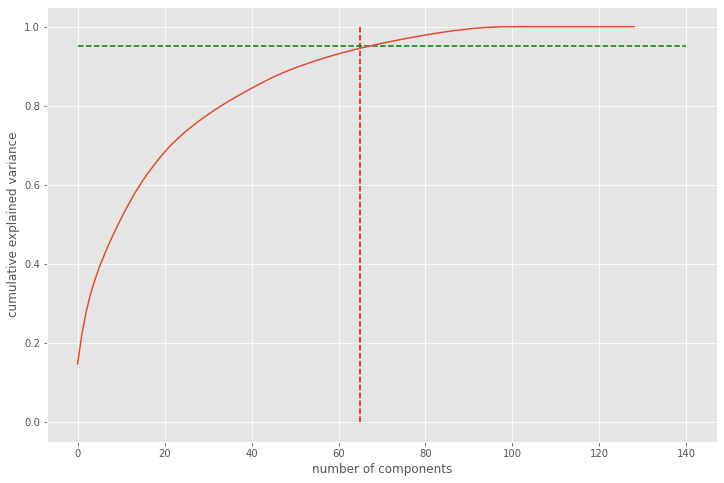

In [210]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=65, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=140, xmin=0, colors="g", linestyles="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We can see that 65 components are able to explain more than 95% of the variance. So lets select the number of components as 65 and create a new dataset

In [211]:
pca = PCA(n_components=65, random_state=100)
X_train_pca = pca.fit_transform(X_train)

In [212]:
columns = [f"PCA{i}" for i in range(1, len(X_train_pca[0]) + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=columns)
X_train_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65
0,-3.111389,-0.298861,0.191628,-0.372766,-2.688108,-1.112918,-0.073036,2.155963,1.409325,0.735736,...,-0.059953,-0.080682,0.249588,-0.070258,0.224894,-0.049688,-0.225520,0.580913,0.461962,0.016878
1,4.383535,-5.240066,-0.820148,-0.009867,0.628561,-3.687218,8.109586,0.009562,-0.871456,-1.561484,...,-0.259388,-0.376350,-0.033021,0.053483,0.276052,0.058588,0.495290,-0.190295,0.268693,-0.466463
2,-2.699459,0.511504,-0.877077,-0.037247,-3.229403,-0.907035,0.404698,0.732195,0.439280,0.612380,...,-0.260805,0.159233,0.081339,0.018109,0.051738,-0.004253,-0.245924,0.481865,0.687932,0.138439
3,-0.419508,0.351818,-1.573326,-0.669010,-2.177216,-1.716949,0.119955,0.662333,-0.373092,0.150905,...,0.095106,0.853666,0.234050,-0.463837,-0.033076,-0.059669,-0.062810,-0.212584,0.609066,0.578720
4,-2.402311,0.941640,-0.809745,-0.564320,0.593192,-0.404254,-0.748105,-0.407250,-0.002902,0.054386,...,0.114805,0.313667,-0.118879,-0.063003,-0.246510,-0.132235,-0.003379,-0.126876,0.226100,0.401938


In [213]:
X_test_pca = pca.transform(X_test)

In [214]:
columns = [f"PCA{i}" for i in range(1, len(X_test_pca[0]) + 1)]
X_test_pca = pd.DataFrame(X_test_pca, columns=columns)
X_test_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65
0,11.765110,2.300779,2.087541,-2.540831,-1.989644,-2.093416,-0.907603,2.591143,1.884516,-0.195069,...,0.116772,1.573627,0.872533,-0.174159,-0.406576,0.156954,0.234775,0.016586,1.300917,0.133157
1,-3.712847,-0.869155,-0.577664,-0.342016,0.193458,0.230729,-0.475190,0.128264,-0.552842,-0.239163,...,-0.158246,-0.008376,-0.230070,0.162175,-0.079988,0.093004,-0.007427,0.069069,-0.148492,0.186334
2,-4.348115,0.401904,-0.959530,-0.453550,0.609562,0.318294,0.689669,-0.301076,-0.090555,-0.742536,...,-0.103943,-0.425112,-0.052531,0.287012,-0.126544,0.153977,0.066493,-0.122147,-0.301666,0.128835
3,2.761143,-4.998560,-0.935071,0.166125,-0.807236,2.325954,2.227444,-2.182551,0.829289,-0.528427,...,0.122043,-0.154409,0.055234,-0.158955,0.062932,0.054720,0.056531,-0.547023,0.530292,-0.024841
4,0.513006,5.732458,-3.393840,0.681178,-3.429344,0.261270,1.996396,-3.104904,-1.178805,0.698015,...,0.382034,0.324386,-0.080025,-0.341312,-0.417811,0.453580,0.039908,-0.134409,-0.114515,0.336535


## 4. Modelling and evaluation

Let's applying LogisticRegression, DecisionTree and RandomForest to see which one gives the highest accuracy

#### Logistic Regression

In [215]:
logistic_pca = LogisticRegression(random_state=100)

In [216]:
model_pca = logistic_pca.fit(X_train_pca, y_train)

In [217]:
pred_probs_train = model_pca.predict_proba(X_train_pca)
pred_train = model_pca.predict(X_train_pca)

In [218]:
print("LR train accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))

LR train accuracy:  0.90608


In [219]:
pred_probs_test = model_pca.predict_proba(X_test_pca)
pred_test = model_pca.predict(X_test_pca)

In [220]:
print("LR test accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))

LR test accuracy:  0.9036


#### Decision tree

Lets do Cross Validation to do hyperparameter tuning

In [221]:
dt = DecisionTreeClassifier(random_state=100)

In [222]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [223]:
%%time
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 5.44 s, sys: 162 ms, total: 5.6 s
Wall time: 57.9 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [224]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=100)

In [225]:
dt_best = grid_search.best_estimator_

In [226]:
pred_probs_train = dt_best.predict_proba(X_train_pca)
pred_train = dt_best.predict(X_train_pca)

In [227]:
print("DT train accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))

DT train accuracy:  0.915


In [228]:
pred_probs_test = dt_best.predict_proba(X_test_pca)
pred_test = dt_best.predict(X_test_pca)

In [229]:
print("DT test accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))

DT test accuracy:  0.90571


#### Random Forest

In [230]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1)

In [231]:
params = {
    'max_depth': [10,20,30,40],
    'min_samples_leaf': [3,5,10,20],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [232]:
%%time
grid_search.fit(X_train_pca, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
CPU times: user 32.2 s, sys: 423 ms, total: 32.6 s
Wall time: 10min 52s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [3, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [233]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_leaf=3, n_estimators=25,
                       n_jobs=-1, random_state=100)

In [234]:
rf_best = grid_search.best_estimator_

In [235]:
pred_probs_train = rf_best.predict_proba(X_train_pca)
pred_train = rf_best.predict(X_train_pca)

In [236]:
print("RF train accuracy: ", round(metrics.accuracy_score(y_train, pred_train), 5))

RF train accuracy:  0.97837


In [237]:
pred_probs_test = rf_best.predict_proba(X_test_pca)
pred_test = rf_best.predict(X_test_pca)

In [238]:
print("RF test accuracy: ", round(metrics.accuracy_score(y_test, pred_test), 5))

RF test accuracy:  0.91364


**Out of all the three Random Forest is giving a better accuracy, let's use that**

### 5. Variable importance

In [239]:
rf_imp = RandomForestClassifier(random_state=100, n_jobs=-1)

In [240]:
params = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [3, 5, 10, 20],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf_imp,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [241]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
CPU times: user 49.3 s, sys: 690 ms, total: 50 s
Wall time: 12min 20s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [3, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [242]:
rf_best_imp = grid_search.best_estimator_

In [243]:
rf_best_imp

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=100)

In [244]:
imp_df = pd.DataFrame({
    "Varname": X.columns,
    "Imp": rf_best_imp.feature_importances_
})

In [245]:
imp_df.sort_values(by="Imp", ascending=False).head(10)

,Varname,Imp
81,total_ic_mou_8,0.147824
53,total_og_mou_8,0.084512
2,arpu_8,0.054446
99,max_rech_amt_8,0.050410
96,total_rech_amt_8,0.047986
80,total_ic_mou_7,0.033124
59,loc_ic_t2m_mou_8,0.032341
65,loc_ic_mou_8,0.031425
52,total_og_mou_7,0.025870
62,loc_ic_t2f_mou_8,0.025352


## Conclusion

**Performing EDA gave us following insights**
- If customer is recharging less month on month he/she is likely to churn
- If customer's revenue is decreasing month on month he/she is likely to churn
- Customer consuming less internet data is likely to churn
- If is a customer has not done recharge lately, he/she might end up churning
- Customer who is using the network for long enough is not likely to churn
- If total voice call usage is declining month over month customer will likely churn

**RandomForestClassifier** gives the best accuracy of **0.91364** with following hyperparameters
- max_depth=30
- min_samples_leaf=3
- n_estimators=25

Few **Important features** are as follows
- Total incoming voice calls in the month of august
- Total outgoing voice calls in the month of august
- Average revenue per user in the month of august
- Total amount of recharge done in the month of august
- Maximum amount of recharge done in the month of august

## Testing with Kaggle test data

In [246]:
df_test = pd.read_csv("test (1).csv")

#### Applying transformations

In [247]:
df_test['date_of_last_rech_6'] = pd.to_datetime(df_test['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [248]:
df_test['date_of_last_rech_7'] = pd.to_datetime(df_test['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [249]:
df_test['date_of_last_rech_8'] = pd.to_datetime(df_test['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [250]:
df_test["total_rech_amt"] = df_test["total_rech_amt_6"] + df_test["total_rech_amt_7"] + df_test["total_rech_amt_8"]

In [251]:
df_test["total_vol_2g_3g"] = df_test["vol_2g_mb_6"] + df_test["vol_2g_mb_7"] + df_test["vol_2g_mb_8"] + df_test["vol_3g_mb_6"] + df_test["vol_3g_mb_7"] + df_test["vol_3g_mb_8"]

In [252]:
df_test["arpu"] = (df_test["arpu_6"] + df_test["arpu_7"] + df_test["arpu_8"] ) / 3

In [253]:
df_test["total_mou"] = df_test["onnet_mou_6"] + df_test["onnet_mou_7"] + df_test["onnet_mou_8"] + df_test["offnet_mou_6"] + df_test["offnet_mou_7"] + df_test["offnet_mou_8"]

#### Dropping columns and treating null values

In [254]:
df_test = df_test[X.columns]

In [255]:
df_test.fillna(df_test.median(), inplace=True)

#### Preparing data

In [256]:
X_test = scaler.transform(df_test)

In [257]:
X_test_pca = pca.transform(X_test)

#### Predicting

In [258]:
pred_probs_test = rf_best.predict_proba(X_test_pca)
pred_test = rf_best.predict(X_test_pca)

#### Preparing output file

In [259]:
df_final = pd.read_csv("solution (1).csv")

In [260]:
df_final.drop("churn_probability", axis=1, inplace=True)

In [261]:
df_final["churn_probability"] = pred_test

In [262]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 30000 non-null  int64
 1   churn_probability  30000 non-null  int64
dtypes: int64(2)
memory usage: 468.9 KB


In [263]:
df_final.to_csv("solution.csv", index=False)